# Feature Importance and Selection:

In [506]:
import numpy as np
import mltools as ml
import matplotlib.pyplot as plt
import sklearn.feature_selection as featureSel
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn import decomposition

In [3]:
X = np.genfromtxt('data/X_train.txt', delimiter=None)
Y = np.genfromtxt('data/Y_train.txt', delimiter=None)
X,Y = ml.shuffleData(X,Y)

In [9]:
Xtr, Xva, Ytr, Yva = ml.splitData(X, Y)
Xt, Yt = Xtr[:20000], Ytr[:20000] # subsample for efficiency (you can go higher)
Xnt, Ynt = Xtr[20000:], Ytr[20000:] # subsample for efficiency (you can go higher)

For simplifying the purpose of selecting features, we only do a held out validation rather than cross-validation.
Cross-validation is done at a later phase when the analysis is done.

# Removing features with low variance

VarianceThreshold is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e. features that have the same value in all samples.

In [43]:
p_arr = [0.9,0.8,0.7,0.6]
res_dim = len(p_arr)*[0]
for i,p in enumerate(p_arr):
    varSel = featureSel.VarianceThreshold(threshold=(p * (1 - p)))
    X_transform = varSel.fit_transform(Xt)
    res_dim[i] = X_transform.shape[1]

print(res_dim)

[14, 14, 14, 14]


Here we observe that on a range of threshold values, all features seem to pass the threshold. Hence, no dimension reduction is performed based on this approach.

# Feature Importance - Random Forests

Feature Importance: Importance/Significance of feature towards the end goal of classification/regression.

Random forests are among the most popular machine learning methods because of their good accuracy and easy to use. They provide two straightforward methods for feature selection:
1. Mean decrease impurity: Based on the information gain from a feature every tree is generated. Thus when training a tree, it can be computed how much each feature decreases the weighted impurity in a tree. For a forest, the impurity decrease from each feature can be averaged and the features are ranked according to this measure.
2. Mean decrease accuracy: Direct measure of impact by each feature on accuracy. Idea is to permute the values of each feature and measure how much the permutation decreases the accuracy.

Here, we use random forest classifier to compute the relative importance of each feature towards the classification.

In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

In [144]:
features = np.array(['Feature 1', 'Feature 2','Feature 3','Feature 4','Feature 5','Feature 6','Feature 7',
                     'Feature 8', 'Feature 9','Feature 10','Feature 11','Feature 12','Feature 13','Feature 14'])
clf = RandomForestClassifier(max_depth=20, random_state=0)
clf.fit(Xt, Yt)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [145]:
importances = clf.feature_importances_
sorted_idx = np.argsort(importances)

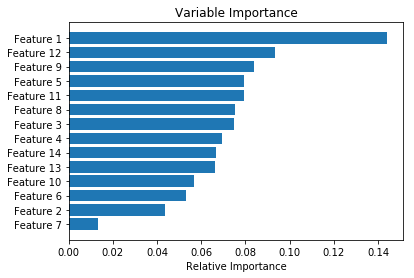

In [146]:
padding = np.arange(len(features)) + 0.5
plt.barh(padding, importances[sorted_idx], align='center')
plt.yticks(padding, features[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

Observations: 
1. Feature 7 seems to be very less contributing towards the overall classification. 
2. Feature 1 seems to influence more than other features.
3. All other features contribute to some extent towards the classification.

To get a greater idea, we explore these combinations and compare the MSE or AUC accuracies for these models.

## Testing Feature 7 removal: Random Forests - Training data set: 20,000 (10%)

## Least Influential feature- Before feature removal:

In [147]:
predictions = clf.predict(Xva)
roc_auc_score(Yva, predictions)

0.61055451954067308

## Least Influential feature- After feature removal:


In [142]:
X_removedFeature = np.delete(Xt, [7], axis=1)
Xva_removedFeature = np.delete(Xva, [7], axis=1)

clf2 = RandomForestClassifier(max_depth=20, random_state=0)
clf2.fit(X_removedFeature, Yt)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [143]:
predictions2 = clf2.predict(Xva_removedFeature)
roc_auc_score(Yva, predictions2)

0.61074784551386874

Here, we observe that AUC has increased. This might be due to the sampled validation partition of the data.
But, nevertheless the AUC has not decreased dramatically which proves less significance of Feature 7.

## Most Influential feature- After feature removal:

In [140]:
X_sig_removedFeature = np.delete(Xt, [1], axis=1)
Xva_sig_removedFeature = np.delete(Xva, [1], axis=1)

clf3 = RandomForestClassifier(max_depth=20, random_state=0)
clf3.fit(X_sig_removedFeature, Yt)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [141]:
predictions3 = clf3.predict(Xva_sig_removedFeature)
roc_auc_score(Yva, predictions3)

0.60955984729155188

Here, we observe that AUC has decreased - Just as per our understanding from learning feature importance!

# Exploring Regression- Random Forests:

Since, classification into 2 classes strictly, is not desired in our case:
We need to only predict the probability of rainfall.

Therefore, using regression would not be a bad idea. Random Forest Regression and Linear/Polynomial regression is done to evaluate the above mentioned feature importance.

## Original Feature Space (with all 14 dimensions):

In [236]:
reg = RandomForestRegressor(max_depth = 10, random_state=0)
reg.fit(Xt, Yt)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [237]:
appxs = reg.predict(Xva)
print("AUC: " + str(roc_auc_score(Yva, appxs)))
print("MSE: " + str(mean_squared_error(Yva, appxs)))

AUC: 0.672215238387
MSE: 0.205323895777


In [203]:
importances = reg.feature_importances_
sorted_idx = np.argsort(importances)

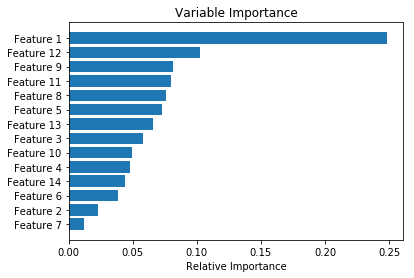

In [204]:
padding = np.arange(len(features)) + 0.5
plt.barh(padding, importances[sorted_idx], align='center')
plt.yticks(padding, features[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

Similar to Random Forrest Classifier based approach for feature importance, feature importance can be calculated in case of a forest regrssor also. The above graph details the results.
Observation: The results are consistent with results of Random Forest Classifier.


## Least Influential feature- After feature removal:

In [184]:
reg2 = RandomForestRegressor(max_depth=10, random_state=0)
reg2.fit(X_removedFeature, Yt)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [205]:
appxs2 = reg2.predict(Xva_removedFeature)
print("AUC: " + str(roc_auc_score(Yva, appxs2)))
print("MSE: " + str(mean_squared_error(Yva, appxs2)))

AUC: 0.669431916909
MSE: 0.205728585462


## Highest Influential feature- After feature removal:

In [181]:
reg3 = RandomForestRegressor(max_depth=10, random_state=0)
reg3.fit(X_sig_removedFeature, Yt)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [206]:
appxs3 = reg3.predict(Xva_sig_removedFeature)
print("AUC: " + str(roc_auc_score(Yva, appxs3)))
print("MSE: " + str(mean_squared_error(Yva, appxs3)))

AUC: 0.671457758885
MSE: 0.205440481453


Here we don't observe the results as in the case of classification! (low/high influential feature VS MSE/AUC)
This might be because, for regression - all other features also play their part and hence influence result more.

Let us compare the regression AUC and MSE for only Most influential and only Least influential feature now :)

## Highest Influential feature Only:

In [231]:
reg4 = RandomForestRegressor(max_depth=10, random_state=0)
reg4.fit(Xt[:,0:1], Yt)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [232]:
appxs4 = reg4.predict(Xva[:,0:1])
print("AUC: " + str(roc_auc_score(Yva, appxs4)))
print("MSE: " + str(mean_squared_error(Yva, appxs4)))

AUC: 0.628102712491
MSE: 0.215221822778


## Least Influential feature Only:

In [226]:
reg5 = RandomForestRegressor(max_depth=10, random_state=0)
reg5.fit(Xt[:,6:7], Yt)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [227]:
appxs5 = reg5.predict(Xva[:,0:1])
print("AUC: " + str(roc_auc_score(Yva, appxs5)))
print("MSE: " + str(mean_squared_error(Yva, appxs5)))

AUC: 0.479493541985
MSE: 0.250831635573


Here, we can clearly observe that, least influential feature when considered for AUC has less than 0.5 and hence is making no contribution to the overall regression.

We can also see that most influential feature has AUC comparabale to that of all features! 
This fact can be used for exploration of using only 1 most influential feature for regression (used for classification though) for regressors with proper modelling other than random forests (beacuase of their immunity towards feature importance).

# Linear Regression

Since forests are immune to feature selection, we now explore it's effect on Linear regressor.

In [282]:
# Rescale
XtS, params = ml.rescale(Xt) # Normalize the features
XvS, _ = ml.rescale(Xva, params) # Normalize the features

## Original Feature Space

In [302]:
lr = make_pipeline(PolynomialFeatures(2), Ridge())
lr.fit(Xt,Yt)
lr_prob = lr.predict( Xva ) # make predictions at xs
print("AUC: " + str(roc_auc_score(Yva, lr_prob)))
print("MSE: " + str(mean_squared_error(Yva, lr_prob)))

AUC: 0.669752488935
MSE: 0.205709808436


Here, the chosen degree - 2, is based on local search on range (1,5) which gives out a better AUC.

## Least Influential feature only:

In [284]:
lr2 = make_pipeline(PolynomialFeatures(1), Ridge())
lr2.fit( XtS[:,6:7], Yt )
lr2_prob = lr2.predict( XvS[:,6:7] ) # make predictions at xs
print("AUC: " + str(roc_auc_score(Yva, lr2_prob)))
print("MSE: " + str(mean_squared_error(Yva, lr2_prob)))

AUC: 0.524373775208
MSE: 0.225620489899


Here, we can clearly observe that picking this feature alone will decrease the performance drastically. 

## Highest Influential feature only:

In [285]:
lr3 = make_pipeline(PolynomialFeatures(1), Ridge())
lr3.fit( XtS[:,0:1], Yt )
lr3_prob = lr3.predict( XvS[:,0:1] ) # make predictions at xs
print("AUC: " + str(roc_auc_score(Yva, lr3_prob)))
print("MSE: " + str(mean_squared_error(Yva, lr3_prob)))

AUC: 0.633878813268
MSE: 0.214234886932


Here, picking only 1 out 14 dimensions lead to comparable performance with respect to original feature space.
Therefore this feature can be considered as most influential - just as proved in Random Forests!

Also, there might be feature correlation for features other than feature 1(most influential) feature 7(least influential). We continue our study further by feature correlation and PCA - dimensionality reduction.

From this discussion we conclude that all features are not required for contribution towards the classification problem at hand. Therefore, the 14 dimensional space can definitely be reduced to smaller dimension.

# PCA - Dimension reduction

Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components.

PCA is done on our dataset to retrieve principal components and the singular/eigen values. These values can therefore determine the effective number of dimension/features enough for future purpose of classification/regression.

In [342]:
pca = decomposition.PCA(n_components=14)
pca.fit(Xt)

PCA(copy=True, iterated_power='auto', n_components=14, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

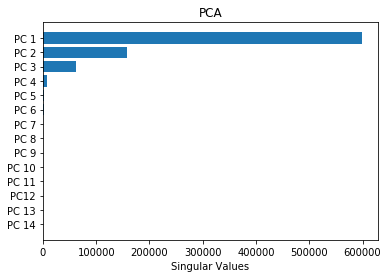

In [348]:
features = np.array(['PC 1', 'PC 2','PC 3','PC 4','PC 5','PC 6','PC 7',
                     'PC 8', 'PC 9','PC 10','PC 11','PC12','PC 13', 'PC 14'])
importances = pca.singular_values_
sorted_idx = np.argsort(importances)
padding = np.arange(len(features)) + 0.5
plt.barh(padding, importances[sorted_idx], align='center')
plt.yticks(padding, features[sorted_idx])
plt.xlabel("Singular Values")
plt.title("PCA")
plt.show()

Here we observe that top 3 or 4 principal components have high significance than the others!
We'll continue on feature correlation to confirm this phenomenon and later use top 3/4 principal directions for classifier tuning.

# Feature Correlation

To observe the extent of inter-feature correlation, Correlation coefficients for each pair of features is computed and a matrix plot is made.

We use Pearson correlation coefficient measures - the linear relationship between two datasets. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact linear relationship.

Along with these coefficients, a p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Pearson correlation at least as extreme as the one computed from these datasets.

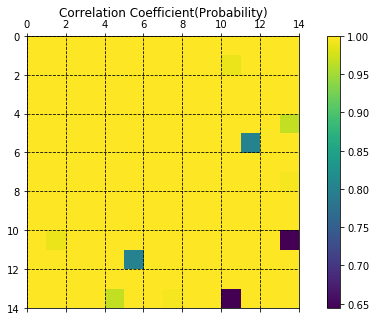

In [444]:
corr_coeff_mat = np.zeros((14,14))
from scipy import stats
for i in range(0,Xt.shape[1],1): 
    for j in range(0, Xt.shape[1],1):
        corr_coeff_mat[i][j]=(1-stats.pearsonr(Xt[:,i:i+1], Xt[:,j:j+1])[1])

        
f, ax = plt.subplots(1, 1, figsize=(10, 5))
cax = ax.matshow(corr_coeff_mat, interpolation='nearest', extent=[0, 14, 14, 0])
f.colorbar(cax)
ax.set_xticklabels(['']+list(range(0,14,1)),minor='true')
ax.set_yticklabels(['']+list(range(0,14,1)),minor='true')
ax.set_title('Correlation Coefficient(Probability)')
plt.grid(True,which='both',color='0',linestyle='--')
plt.show()

Here, we can observe the correlation is very high among features.
We conclude that many of the features have high correlation and hence not required for classification as they are redundant. As per the earlier PCA analysis top 3 to 4 features are unrelated which will be picked for further detailed study.
This concludes our study on dimensionality reduction and feature engineering.

## Effect of PCA on Neural Network (MLFFNN):

Transform Data to top 4 PCA dimensions:

In [493]:
pca = decomposition.PCA(n_components=4)
Xt_red = pca.fit_transform(XtS)
Xva_red = pca.fit_transform(XvS)

In [494]:
def AUC_NN(XtS, Yt, XvS, Yva, nodes_range, layers_range):
    tr_auc = np.zeros(shape = (len(layers_range),len(nodes_range)))
    va_auc = np.zeros(shape = (len(layers_range),len(nodes_range)))
    
    for i,nLayers in enumerate(layers_range):
        for j,nNodes in enumerate(nodes_range):
            nn = ml.nnet.nnetClassify()
            
            design_layers = [nNodes] * (nLayers + 2)
            design_layers[0] = XtS.shape[1]
            design_layers[len(design_layers)-1] = 2
            
            nn.init_weights(design_layers, 'random', XtS, Yt) # as many layers nodes you want
            nn.train(XtS, Yt, stopTol=1e-8, stepsize=.25, stopIter=300)
                        
            tr_auc[i][j] = nn.auc(XtS, Yt)
            va_auc[i][j] = nn.auc(XvS, Yva)
    
    return (tr_auc, va_auc)

In [505]:
nodes_range = [2,4,8,12,16,24]
layers_range = [1,2,4,6,8] # hidden layers
tr_auc_4 = np.zeros(shape = (len(layers_range),len(nodes_range)))
va_auc_4 = np.zeros(shape = (len(layers_range),len(nodes_range)))
tr_auc_4, va_auc_4 = AUC_NN(Xt_red[:5000], Yt[:5000], Xva_red[:2000], Yva[:2000], nodes_range, layers_range)

it 1 : Jsur = 0.4258623982422616, J01 = 0.3278
it 2 : Jsur = 0.42085038510082723, J01 = 0.312
it 4 : Jsur = 0.42108332625182865, J01 = 0.3094
it 8 : Jsur = 0.4209881821209482, J01 = 0.309
it 16 : Jsur = 0.4212942841870805, J01 = 0.3128
it 32 : Jsur = 0.4220169845774556, J01 = 0.3136
it 64 : Jsur = 0.4228719096605686, J01 = 0.3144
it 128 : Jsur = 0.4233649077701035, J01 = 0.3134
it 256 : Jsur = 0.42337137435094874, J01 = 0.3142
it 1 : Jsur = 0.4272120799913409, J01 = 0.3168
it 2 : Jsur = 0.425424266682482, J01 = 0.3164
it 4 : Jsur = 0.42375226430357543, J01 = 0.3164
it 8 : Jsur = 0.42124379760438313, J01 = 0.3148
it 16 : Jsur = 0.41829214458500774, J01 = 0.3162
it 32 : Jsur = 0.41436362001644794, J01 = 0.3112
it 64 : Jsur = 0.41068727130412924, J01 = 0.305
it 128 : Jsur = 0.41066644889105364, J01 = 0.3066
it 256 : Jsur = 0.41144624653304, J01 = 0.308
it 1 : Jsur = 0.4260948645861921, J01 = 0.3194
it 2 : Jsur = 0.4247436966760005, J01 = 0.3254
it 4 : Jsur = 0.4185239837051149, J01 = 0.31

it 4 : Jsur = 0.444491553135428, J01 = 0.3334
it 8 : Jsur = 0.44449262414436125, J01 = 0.3334
it 16 : Jsur = 0.44448967895696895, J01 = 0.3334
it 1 : Jsur = 0.4451980101802593, J01 = 0.3334
it 2 : Jsur = 0.4446446679313912, J01 = 0.3334
it 4 : Jsur = 0.44449155313809025, J01 = 0.3334
it 8 : Jsur = 0.4444926241460456, J01 = 0.3334
it 16 : Jsur = 0.444489678956856, J01 = 0.3334
it 1 : Jsur = 0.44519801002072507, J01 = 0.3334
it 2 : Jsur = 0.4446446679573203, J01 = 0.3334
it 4 : Jsur = 0.44449155319266503, J01 = 0.3334
it 8 : Jsur = 0.4444926241543437, J01 = 0.3334
it 16 : Jsur = 0.4444896789562932, J01 = 0.3334
it 1 : Jsur = 0.4451980101539233, J01 = 0.3334
it 2 : Jsur = 0.4446446679937772, J01 = 0.3334
it 4 : Jsur = 0.44449155318768946, J01 = 0.3334
it 8 : Jsur = 0.4444926241522724, J01 = 0.3334
it 16 : Jsur = 0.44448967895642016, J01 = 0.3334


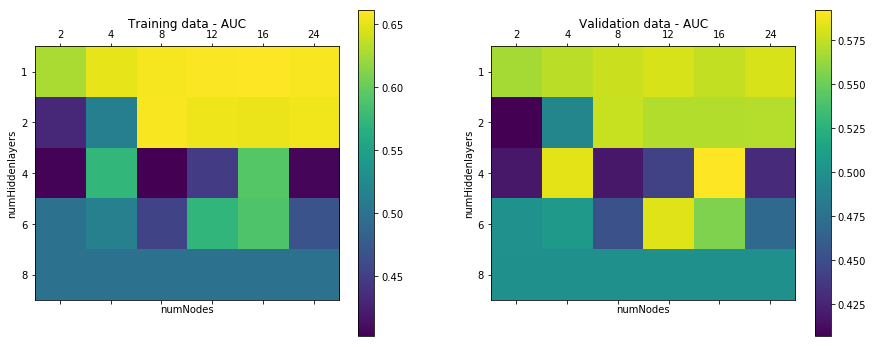

In [507]:
# Now plot it
f, ax = plt.subplots(1, 2, figsize=(15, 6))
cax = ax[0].matshow(tr_auc_4, interpolation='nearest')
f.colorbar(cax, ax = ax[0])
ax[0].set_xlabel("numNodes")
ax[0].set_ylabel("numHiddenlayers")
ax[0].set_xticklabels(['']+ nodes_range)
ax[0].set_yticklabels(['']+ layers_range)
ax[0].set_title('Training data - AUC')

dax = ax[1].matshow(va_auc_4, interpolation='nearest')
f.colorbar(dax, ax = ax[1])
ax[1].set_xlabel("numNodes")
ax[1].set_ylabel("numHiddenlayers")
ax[1].set_xticklabels(['']+nodes_range)
ax[1].set_yticklabels(['']+ layers_range)
ax[1].set_title('Validation data - AUC')

plt.show()

From the above plots (Validation data - AUC), we observe that highest AUC is observed at numHiddenlayers = 1 and numNodes = 16. This combination of parameters gives highest AUC in both train and validatio data. Hence, numHiddenlayers = 1 and numNodes = 16 would be the best parameters to choose. (There are other validation AUCs with higher values but are not chosen because of the discontinous behavior. This might have been caused based on the validation data set sampling. In any case, the AUC does not change much compared to the continous range near 1-layer 16-nodes)

Also, we observe that, the next highest AUC is observed at numHiddenlayers = 2 and numNodesinHiddenLayer = 8. Therefore, a total number of 16 hidden nodes. We can conclude from these observations that, any of these parameters can be chosen.

We also observe that, higher the number of layers, higher the numNodes per layer would increase AUC (and require many iterations and lower step size) and hence performance. But this leads to complex network and hence not chosen.

### PCA MLFFNN Conclusion:

The above mentioned parameters of 16 nodes in 1 layer and 10 nodes in 2 layers are chosen as the best parameters.
Based on these parameters, the whole of training data set is trained with PCA applied.

Interesting Observation:
- The result of PCA utilized for Neural Networks tuning leads to almost the same model as concluded in Assignment 4 (without PCA and dimensionality reduction).
- This indicates that, Neural Network model does not change with PCA/dimensionality reduction which implies
    1. PCA did not effect on the overall prediction (classification/regression)
    2. PCA can be done and then equivalent results can be achieved with significantly less amount of data (here, 10/14) are reduced.

Kaggle Team Name: Weder Praedictio Leaderboard AUC: 0.54354